In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time
import pandas as pd 
import networkx as nx
import jgraph

## Read data 

In [2]:
actors = pd.read_table("movie_nodes.txt",index_col=0,names=["name"])
edges = pd.read_table("movie_edgesw.txt",names=["a","b","weight"])
actor_ind = actors.index

## Create a graph 

In [3]:
G = nx.Graph()
G.add_weighted_edges_from(edges.values)

## Since there's too many nodes, we seperate the graphs into groups

In [4]:
from community import community_louvain
partition = community_louvain.best_partition(G)

In [5]:
par_ser = pd.Series(partition)
par_ser.value_counts()[:45]

3      5063
0      3188
2      3058
1      3056
6      2225
8      1920
7      1634
12     1403
5      1255
4       817
14      483
11      450
10      445
9       419
13      277
15      250
16      187
17      153
19      118
18      107
29       44
22       41
24       24
20       23
52       19
184      11
91       11
30        9
100       8
180       8
111       7
182       7
77        6
85        6
49        6
21        5
70        5
28        5
41        5
149       5
125       5
109       5
81        5
198       5
156       4
dtype: int64

In [69]:
selected_nodes = par_ser[par_ser==29].index # select the group size around 40
H = nx.subgraph(G,selected_nodes)

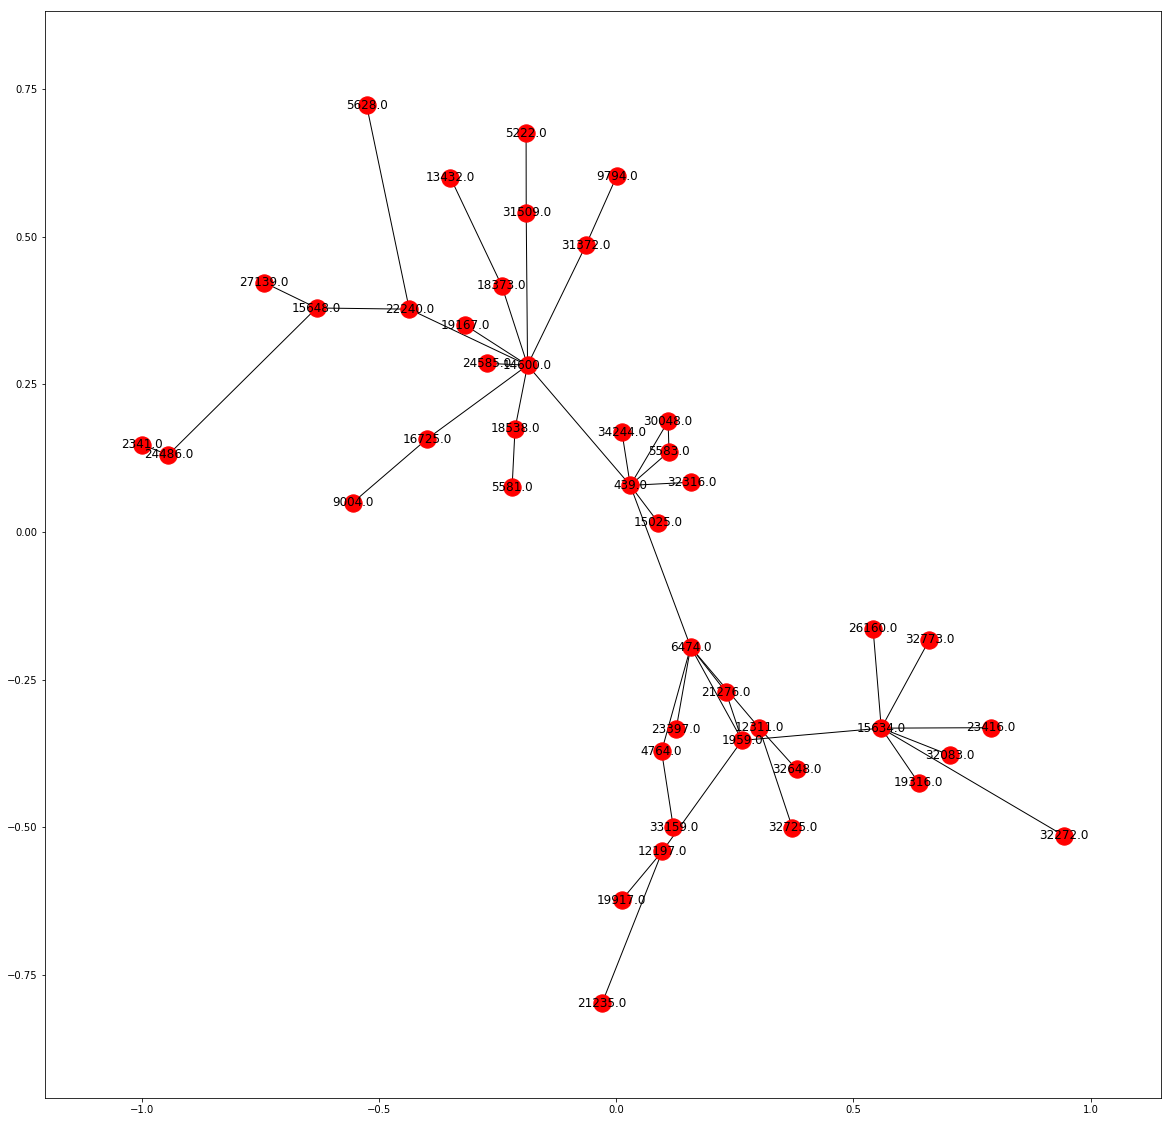

In [70]:
plt.figure(figsize=(20,20))
nx.draw_networkx(H)

In [8]:
def get_prob(G,node):
    raw_info = G[node]
    probs = [i["weight"]  for i in dict(G[node]).values()]
    neighbor_node = list(G.neighbors(node))
    return np.array(neighbor_node), np.array(probs)

In [9]:
def IC(g,S,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine those neighbors that become infected
                #np.random.seed(i)
                try:
                    neighbor_nodes,neighbor_prob = get_prob(g,node)
                except:
                    print(node)
                    print(S)
                success = np.random.uniform(0,1,len(neighbor_nodes)) < neighbor_prob
                new_ones += list(np.extract(success,neighbor_nodes))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active

        spread.append(len(A))
        
    return(np.mean(spread))

In [10]:
def greedy(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()
    
    # Find k nodes with largest marginal gain
    for _ in range(k):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        for j in set(g.nodes())-set(S):

            # Get the spread
#             print(S,[j])
            s = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if s > best_spread:
                best_spread, node = s, j

        # Add the selected node to the seed set
        S.append(node)
        
        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)

In [11]:
def celf(g,k,mc=1000):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    all_nodes = g.nodes()
    marg_gain = [IC(g,[node],mc) for node in all_nodes]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(all_nodes,marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [len(all_nodes)], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

## Define a function for neighbor solution 

In [54]:
def neighbor(Graph, seed,p):
    flag = True
    a = set()
    for k in seed:
        a.update(Graph.neighbors(k))
    a.update(list(Graph.nodes()))
    while flag:
        random_num = np.random.randint(4)
        random_prob = uniform(0, 1)
        for i in range(len(p)):
            if (random_prob > p[i-1]) and (random_prob < p[i]) and \
            list(Graph.nodes())[i] != seed[random_num] and list(Graph.nodes())[i] not in a:
                seed[random_num] = list(Graph.nodes())[i]
                flag = False
    return seed

In [71]:
class Simulation_Annealing:
    
    def __init__(self,Graph ,temperature, cool_rate,top_k,
                 loss_function, tolerance,iter_temperature,
                 max_iter=20000 ):
        '''
        Temperature decreasing with velocity `cooling_rate`
        Algorithm stop when temperature below tolerance or exceed max iteration.
        '''
        self.G = Graph
        self.T = temperature
        self.cooling_rate = cool_rate
        self.k = top_k
        self.E = loss_function
        self.tol = tolerance
        self.iter_loop = iter_temperature
        self.max_iter = max_iter
        self.history = {'x' : [], 'E' : []}
         
    def run(self):
        # prepare for select new nodes 
#         IC_list = []
#         for i in list(self.G.nodes()):
#             IC_list.append(IC(self.G, [i]))
#         IC_sum = sum(IC_list)
#         p = []
#         p.append(IC_list[0]/IC_sum)
#         for i in range(1, len(IC_list)):
#             p.append(p[i-1]+IC_list[i]/IC_sum)
        i = 0 
        
        # create initial state 
        pre  = np.random.choice(self.G.nodes(), size=self.k, replace=False).tolist()
        energy_pre = self.E(self.G,pre)
        print("Initial state:",pre)
        
        #prevent energry influenced by IC 
        effect = {}
        effect[tuple(sorted(pre))] = energy_pre
        
        # SA begins
        while (self.T > self.tol) and (i < self.max_iter):
            for _ in range(self.iter_loop):
                new_state = np.random.choice(self.G.nodes(), size=self.k, replace=False).tolist()
#                 new_state = neighbor(self.G,pre,p)
#                 print(pre,new_state)
                assert not new_state==pre 
                if tuple(sorted(new_state)) in effect:
                    energy_new = effect[tuple(sorted(new_state))]
                else:
                    energy_new = self.E(self.G,new_state)
                    effect[tuple(sorted(new_state))] = energy_new
                delta_E = energy_new - energy_pre

                if delta_E > 0:
                    pre, energy_pre = new_state, energy_new

                elif uniform(0,1) < np.exp(delta_E/self.T):
                    pre, energy_pre = new_state, energy_new
                self.history['x'].append(pre)
                self.history['E'].append(energy_pre)

                    
            self.T *= self.cooling_rate
            # T /= rate seems to converge slow

            i+=1

        self.final = self.history["x"][np.argmax(self.history["E"])]
        return self.final
            
    def plot(self, **kargs):
        plt.title('History energy')
        plt.xlabel('Iteration')
        plt.ylabel('Energy')
        plt.plot(self.history['E'], **kargs)
        

In [84]:
# Run algorithms
celf_output   = celf(H,4,mc=1000)
# greedy_output = greedy(H,4,p=0.2,mc=1000)

# Print results
print("celf output:   " + str(celf_output[0]))
# print("greedy output: " + str(greedy_output[0]))

celf output:   [439.0, 15634.0, 24486.0, 15648.0]


In [92]:
sa = Simulation_Annealing(H,10,0.8,4,IC,1,5,max_iter=200)
sa_output = sa.run()
print("sa output:     " + str(sa_output))

Initial state: [32725.0, 12197.0, 16725.0, 24486.0]
sa output:     [439.0, 15648.0, 5222.0, 19316.0]


In [43]:
celf_output

([26433.0, 16386.0, 15917.0, 23962.0],
 [19.377, 27.035, 29.266, 30.579],
 [22.201488971710205, 54.45051980018616, 80.13622498512268, 85.21064710617065],
 [41, 34, 22, 4])

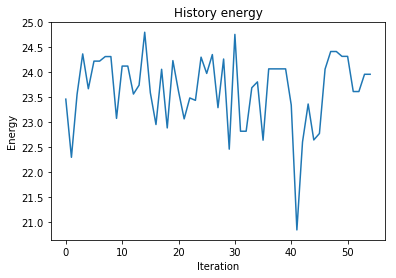

In [73]:
sa.plot()

## Visualize

In [78]:
def IC_node(g,S):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
        
    # Simulate propagation process      
    new_active, A = S[:], S[:]
    while new_active:

        # For each newly active node, find its neighbors that become activated
        new_ones = []
        for node in new_active:

            # Determine those neighbors that become infected
            #np.random.seed(i)
            try:
                neighbor_nodes,neighbor_prob = get_prob(g,node)
            except:
                print(node)
                print(S)
            success = np.random.uniform(0,1,len(neighbor_nodes)) < neighbor_prob
            new_ones += list(np.extract(success,neighbor_nodes))

        new_active = list(set(new_ones) - set(A))

        # Add newly activated nodes to the set of activated nodes
        A += new_active
        
    return A

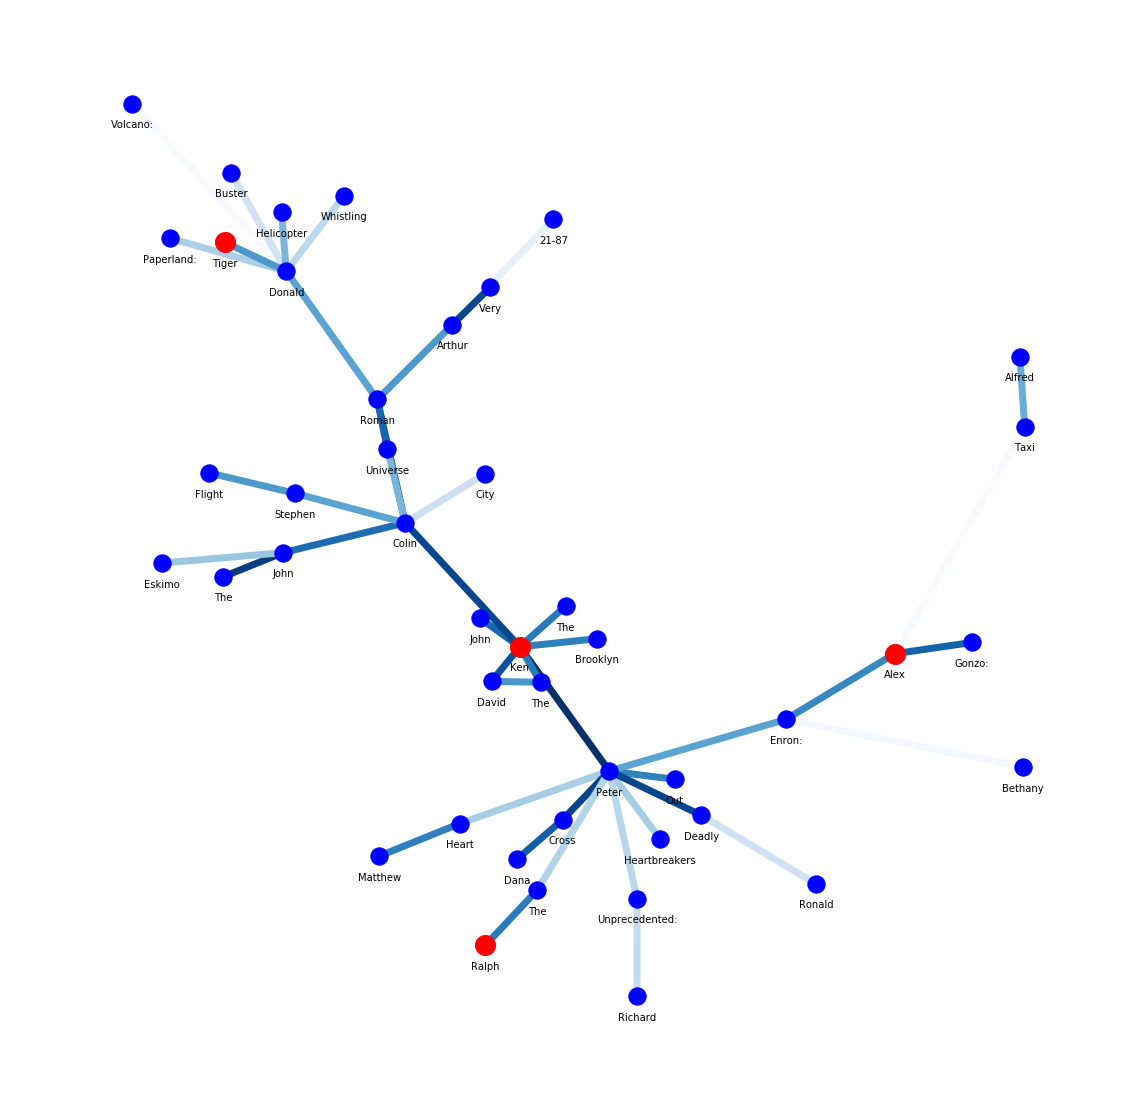

In [93]:
pos = nx.spring_layout(H)
plt.figure(figsize=(15,15))
edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
nx.draw(H, pos, node_color="b", width=7, edgelist=edges, edge_color=weights,edge_cmap=plt.cm.Blues)
nx.draw_networkx_nodes(H, pos, sa_output, node_color="r", node_size=400)
#node label 
all_name = actors.to_dict()["name"]
lbl = {}
for node in H.nodes():
    lbl[node] = all_name[node].split(" ")[0]
for node, val in pos.items():
    x,y = val
    plt.text(x,y-0.05,s=lbl[node], horizontalalignment='center')
plt.savefig("initial")

30


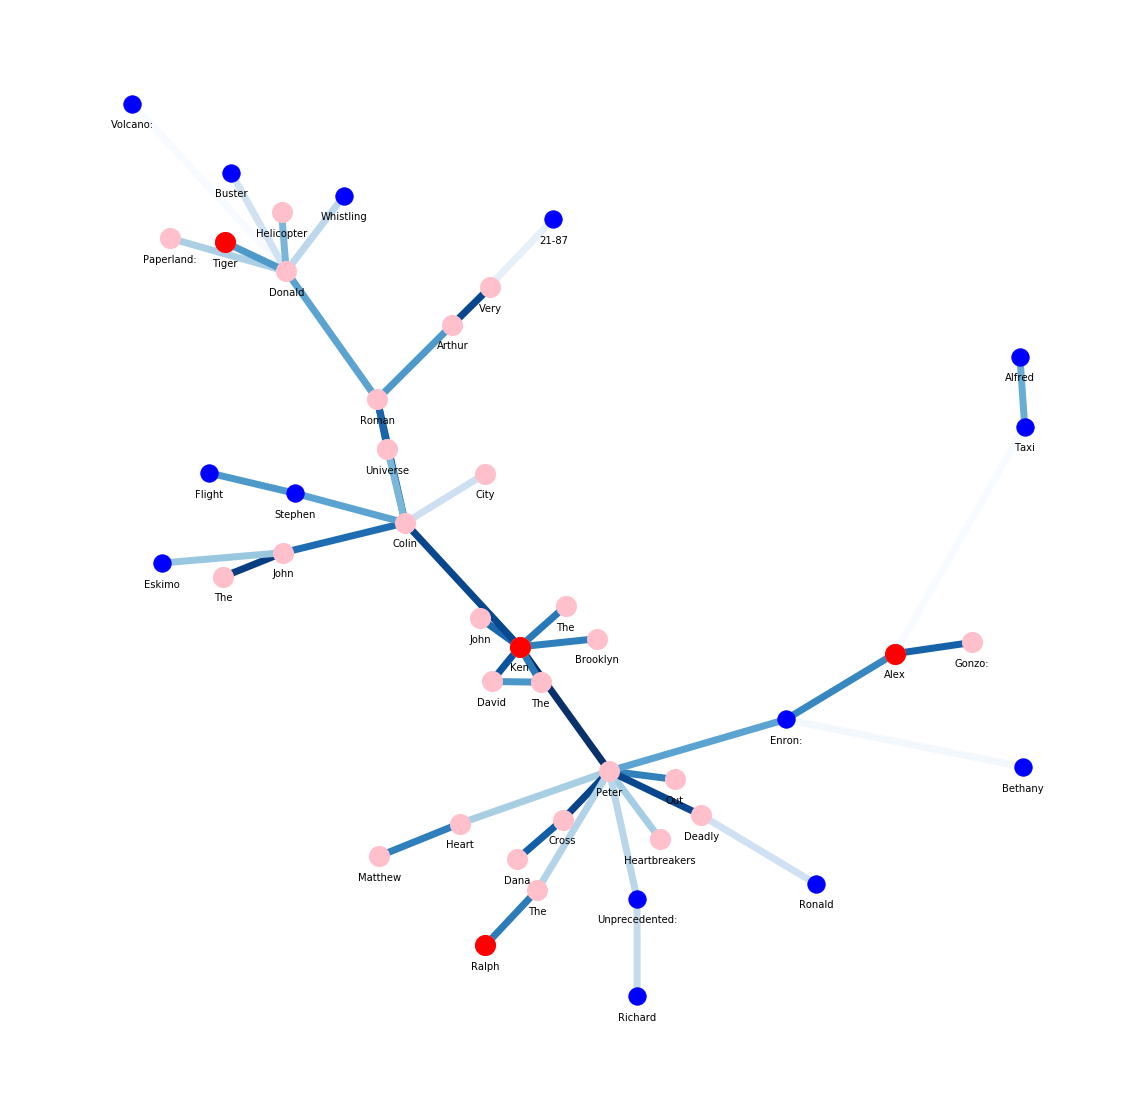

In [94]:
result = IC_node(H,sa_output)
plt.figure(figsize=(15,15))
edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
nx.draw(H, pos, node_color="b", width=7, edgelist=edges, edge_color=weights,edge_cmap=plt.cm.Blues)
nx.draw_networkx_nodes(H, pos, result, node_color="pink", node_size=400)
nx.draw_networkx_nodes(H, pos, sa_output, node_color="r", node_size=400)
print(len(result))

#node label 
all_name = actors.to_dict()["name"]
lbl = {}
for node in H.nodes():
    lbl[node] = all_name[node].split(" ")[0]
for node, val in pos.items():
    x,y = val
    plt.text(x,y-0.05,s=lbl[node], horizontalalignment='center')
plt.savefig("propogate_result",dpi=500)

## Randomly choose 4 nodes

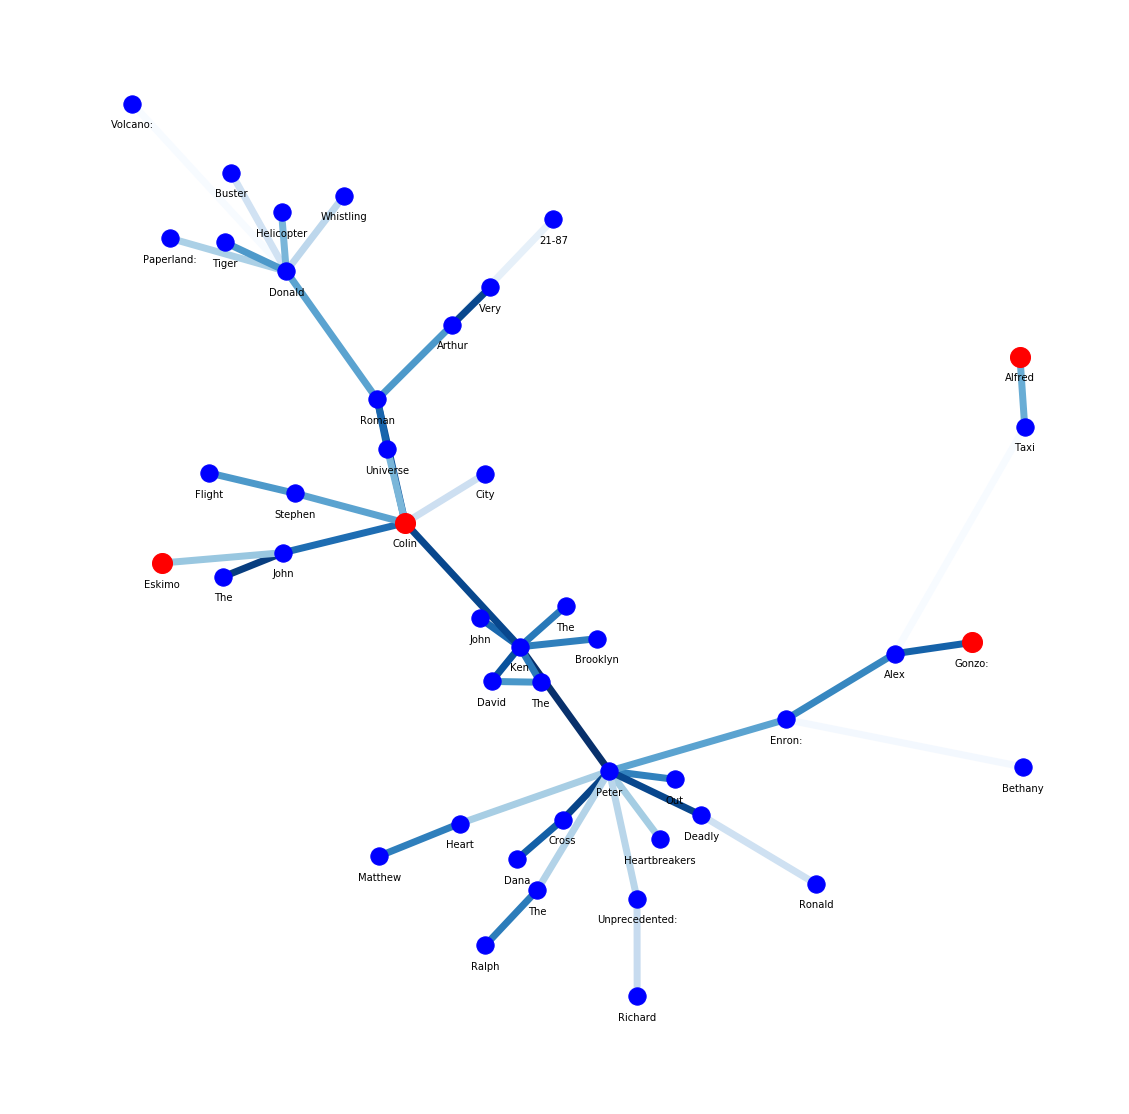

In [95]:
#select node 
rd_nodes = np.random.choice(list(H.nodes()),4,replace=False).tolist()

plt.figure(figsize=(15,15))

edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
nx.draw(H, pos, node_color="b", width=7, edgelist=edges, edge_color=weights,edge_cmap=plt.cm.Blues)
nx.draw_networkx_nodes(H, pos, rd_nodes, node_color="r", node_size=400)
#node label 
all_name = actors.to_dict()["name"]
lbl = {}
for node in H.nodes():
    lbl[node] = all_name[node].split(" ")[0]
for node, val in pos.items():
    x,y = val
    plt.text(x,y-0.05,s=lbl[node], horizontalalignment='center')
plt.savefig("rd_init")

23


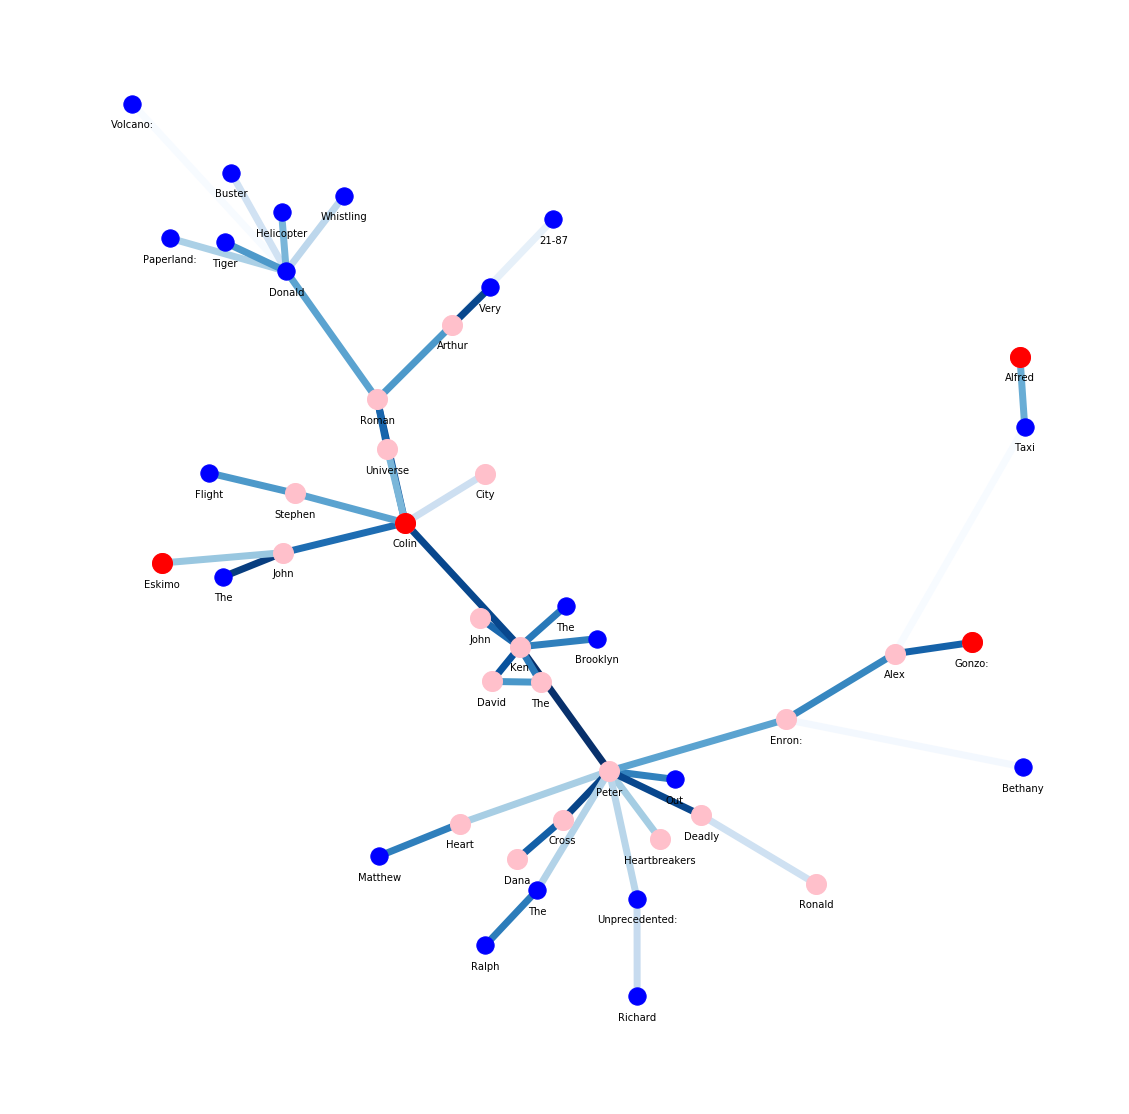

In [96]:
result = IC_node(H,rd_nodes)
plt.figure(figsize=(15,15))
edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
nx.draw(H, pos, node_color="b", width=7, edgelist=edges, edge_color=weights,edge_cmap=plt.cm.Blues)
nx.draw_networkx_nodes(H, pos, result, node_color="pink", node_size=400)
nx.draw_networkx_nodes(H, pos, rd_nodes, node_color="r", node_size=400)
print(len(result))
#node label 
all_name = actors.to_dict()["name"]
lbl = {}
for node in H.nodes():
    lbl[node] = all_name[node].split(" ")[0]
for node, val in pos.items():
    x,y = val
    plt.text(x,y-0.05,s=lbl[node], horizontalalignment='center')
plt.savefig("rd_result",dpi=500)

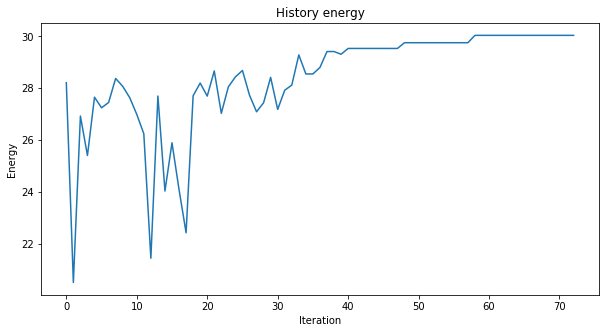

In [52]:
plt.figure(figsize=(10,5))
sa.plot()

In [58]:
sa.history["x"]

[[21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1522.0],
 [21795.0, 3291.0, 8779.0, 1

In [ ]:
def init():
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    nx.draw(H, pos, node_color="b", width=7, edgelist=edges, edge_color=weights,edge_cmap=plt.cm.Blues)
    nx.draw_networkx_nodes(H, pos, rd_nodes, node_color="r", node_size=400)
    #node label 
    all_name = actors.to_dict()["name"]
    lbl = {}
    for node in H.nodes():
        lbl[node] = all_name[node].split(" ")[0]
    for node, val in pos.items():
        x,y = val
        plt.text(x,y-0.05,s=lbl[node], horizontalalignment='center')
def animate(i):
    

fig = plt.figure(figsize=(10, 10))
ani = animation.FuncAnimation(fig=fig, func=animate, frames=1000, init_func=init, interval=1000, repeat=False, blit=True)
plt.show()

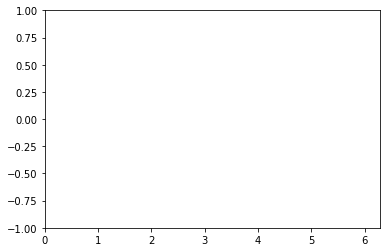

In [57]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t),interval=20)

from IPython.display import HTML
HTML(ani.to_jshtml())